In [1]:
import jax.numpy as jnp
import jax
from jax import vmap, jit, jacfwd
import optax
from functools import partial
import numpy as np
from tqdm import trange
from jax import grad
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../')

from KANWrapper import SF_KAN

# Create interior points
L_range = (-1.0, 1.0)
H_range = (-1.0, 1.0)
nx, ny = 200, 200
x = np.linspace(L_range[0], L_range[1], nx)
y = np.linspace(H_range[0], H_range[1], ny)
X, Y = np.meshgrid(x, y)
xy_domain = np.column_stack((X.ravel(), Y.ravel()))

# Create boundary points
x_boundary = np.concatenate([np.full(ny, L_range[0]), np.full(ny, L_range[1]), x, x])
y_boundary = np.concatenate([y, y, np.full(nx, H_range[0]), np.full(nx, H_range[1])])
xy_boundary = np.column_stack((x_boundary, y_boundary))


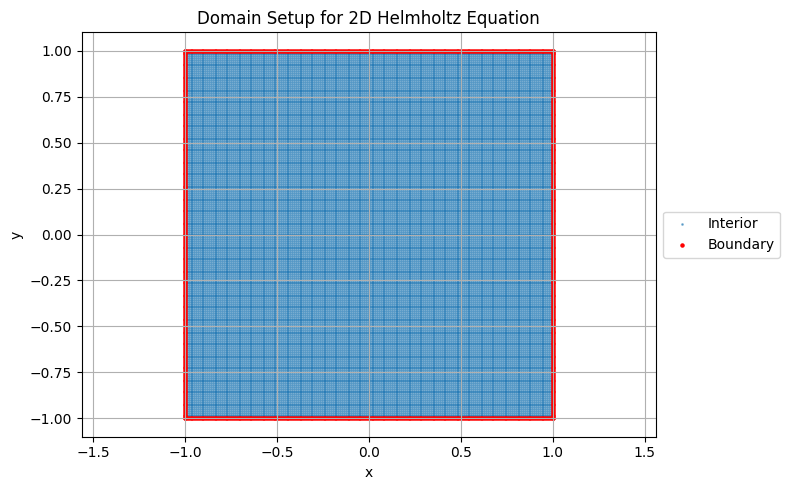

In [2]:
def plot_domain_setup(xy_domain, xy_boundary):
    plt.figure(figsize=(8, 5))
    
    # Plot interior points
    plt.scatter(xy_domain[:, 0], xy_domain[:, 1], s=1, alpha=0.5, label='Interior')
    
    # Plot boundary points
    plt.scatter(xy_boundary[:, 0], xy_boundary[:, 1], s=5, c='r', label='Boundary')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Domain Setup for 2D Helmholtz Equation')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()


plot_domain_setup(xy_domain, xy_boundary)


In [3]:
class Helmholtz_SF_KAN(SF_KAN):
    def __init__(self, *args, kappa=1.0, a1=1.0, a2=4.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.kappa = kappa
        self.a1 = a1
        self.a2 = a2

    @partial(jit, static_argnums=(0,))
    def loss_fn(self, params, state, xy_domain, xy_boundary):
        variables = {'params': params, 'state': state}
        
        # Compute predictions and regularization for all points at once
        all_points = jnp.vstack([xy_domain, xy_boundary])
        preds, spl_regs = self.forward_pass(variables, all_points)
        
        # Split predictions for domain and boundary
        n_domain = xy_domain.shape[0]
        preds_domain = preds[:n_domain]
        preds_boundary = preds[n_domain:]
        
        # Physics loss (Helmholtz equation)
        def helmholtz_residual(pred, x, y):
            u = pred[0]  # Single output for Helmholtz

            # Define the forward pass for computing u
            def compute_u(inp):
                preds_single, _ = self.forward_pass(variables, inp.reshape(1, -1))
                return preds_single[0, 0]  # Corrected indexing

            # First derivatives
            du_dx = jax.grad(compute_u, argnums=0)(jnp.array([x, y]))[0]
            du_dy = jax.grad(compute_u, argnums=0)(jnp.array([x, y]))[1]

            # Second derivatives
            d2u_dx2 = jax.grad(lambda inp: jax.grad(compute_u, argnums=0)(inp)[0])(jnp.array([x, y]))[0]
            d2u_dy2 = jax.grad(lambda inp: jax.grad(compute_u, argnums=0)(inp)[1])(jnp.array([x, y]))[1]

            # Compute the forcing term q(x,y)
            q = (
                -(self.a1 * jnp.pi)**2 * jnp.sin(self.a1 * jnp.pi * x) * jnp.sin(self.a2 * jnp.pi * y) +
                jnp.sin(self.a1 * jnp.pi * x) * jnp.sin(self.a2 * jnp.pi * y) -
                (self.a2 * jnp.pi)**2 * jnp.sin(self.a1 * jnp.pi * x) * jnp.sin(self.a2 * jnp.pi * y) +
                self.kappa**2 * jnp.sin(self.a1 * jnp.pi * x) * jnp.sin(self.a2 * jnp.pi * y)
            )

            return d2u_dx2 + d2u_dy2 + self.kappa**2 * u - q

        # Vectorize the residual computation over all domain points
        residuals = vmap(helmholtz_residual)(preds_domain, xy_domain[:, 0], xy_domain[:, 1])
        physics_loss = jnp.mean(residuals**2)

        # Boundary loss
        def boundary_loss_fn(pred, x, y):
            u = pred[0]
            return u**2  # All boundaries should be zero for Helmholtz

        boundary_losses = vmap(boundary_loss_fn)(preds_boundary, xy_boundary[:, 0], xy_boundary[:, 1])
        boundary_loss = jnp.mean(boundary_losses)

        # Regularization loss
        flattened_spl_reg = [jnp.ravel(arr) for arr in spl_regs]
        reg_loss = jnp.sum(jnp.concatenate(flattened_spl_reg))
        
        # Total loss
        total_loss = physics_loss + boundary_loss #+ reg_loss
        return total_loss




In [4]:
# Model parameters
layer_dims = [2, 9, 9, 1]  # Input dim is 2 (x, y), output dim is 1 (u)
init_lr = 1e-3
k = 3 # KAN spline order

# Helmholtz equation parameters
kappa = 1.0
a1 = 1.0
a2 = 4.0

model = Helmholtz_SF_KAN(
    layer_dims=layer_dims,
    init_lr=init_lr,
    k=k,
    kappa=kappa,
    a1=a1,
    a2=a2
)

# Train the model
num_epochs = 20000
final_variables, loss_history = model.train(num_epochs=num_epochs, xy_domain=xy_domain, xy_boundary=xy_boundary)


100%|██████████| 20000/20000 [5:20:19<00:00,  1.04it/s, Loss=8.740355]   


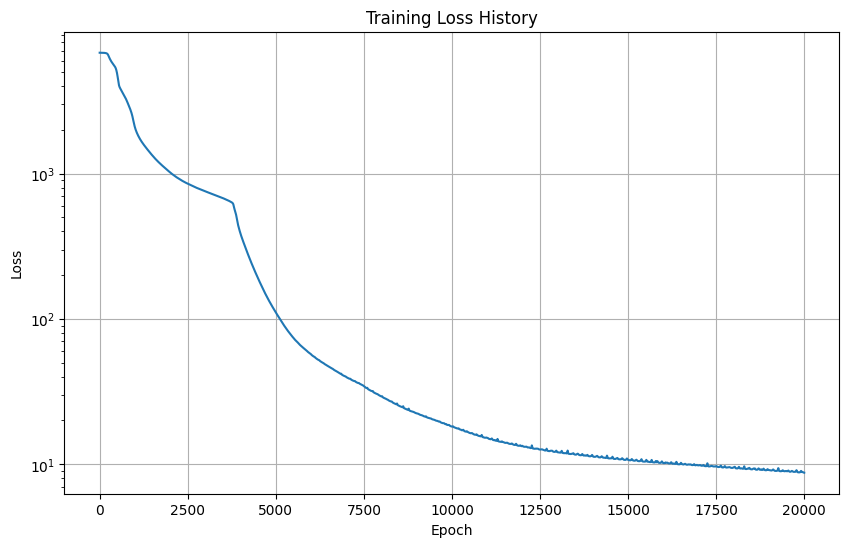

In [5]:
# Plot loss history
def plot_loss_history(loss_history):
    plt.figure(figsize=(10, 6))
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  # Use log scale for y-axis
    plt.title('Training Loss History')
    plt.grid(True)
    plt.show()

plot_loss_history(loss_history)

In [6]:

# Generate solution
nx_plot, ny_plot = nx, ny
x_plot = np.linspace(-1, 1, nx_plot)
y_plot = np.linspace(-1, 1, ny_plot)
X_mesh, Y_mesh = np.meshgrid(x_plot, y_plot)
xy_plot = np.column_stack((X_mesh.ravel(), Y_mesh.ravel()))

u_pred, _ = model.forward_pass({'params': final_variables['params'], 'state': final_variables['state']}, jnp.array(xy_plot))
u_pred = u_pred.reshape(nx_plot, ny_plot)


# Create dictionary with all field data
output_data = {
    'x': x_plot,
    'y': y_plot,
    'u': u_pred,
    'k':k,
    'a1':a1,
    'a2':a2
}

# Save data
np.save(f'./data/2d_helmholtz_pikan_nx{nx}_ny{ny}_{layer_dims}.npy', output_data)




In [7]:
def count_trainable_params(params):
    flat_params, _ = jax.tree_util.tree_flatten(params)
    return sum(p.size for p in flat_params)

num_params = count_trainable_params(final_variables['params'])
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 883
